# 適応線スペクトル強調器（ALE）ハンズオン

## 1. 準備：ライブラリと可視化関数
ここではALE用の可視化関数を定義します。レイアウトは前回のシステム同定デモと完全に統一しています。

+ 1段目（学習曲線）: ノイズが除去されていく過程（誤差の減少）を表示。

+ 2段目（フィルタ係数）: ここがALEの面白さです。ノイズに埋もれていた **信号の周期性** が、フィルタ係数の形として浮き上がってきます。

+ 3段目（波形）: 「ノイズまみれの入力」と「クリーニングされた出力」を比較します。

In [7]:
# @title 1. システムの準備（ライブラリと可視化関数）
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import librosa
from IPython.display import Audio, display
import io

try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# --- 評価指標 ---
def calc_mse_db(error_signal):
    mse = np.mean(error_signal**2)
    return 10 * np.log10(mse + 1e-10)

# --- 可視化用関数 (System IDデモとレイアウトを統一) ---
def plot_ale_results(error_log, w_est, input_sig, output_sig, fs):
    """
    error_log: 学習曲線
    w_est: 推定されたフィルタ係数 (ALEでは周期性が現れる)
    input_sig: ノイズ混じりの入力
    output_sig: 強調された出力 (Enhanced Signal)
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), constrained_layout=True)

    # カラー設定 (統一)
    col_in  = '#1f77b4'   # 青 (入力/Desired)
    col_out = '#ff7f0e'   # オレンジ (出力/Enhanced)
    col_err = '#2ca02c'   # 緑 (誤差/Noise)

    # --- 1段目: 学習曲線 ---
    ax1 = axes[0]
    window = 200
    if len(error_log) > window:
        smooth_curve = np.convolve(error_log, np.ones(window)/window, mode='valid')
        ax1.plot(smooth_curve, color=col_err, linewidth=2, label='Squared Error (Noise Power)')
    else:
        ax1.plot(error_log, color=col_err, alpha=0.6)

    ax1.set_title("1. Learning Curve (Noise Reduction Process)", fontsize=14)
    ax1.set_ylabel("Squared Error (log scale)")
    ax1.set_xlabel("Iterations")
    ax1.set_yscale('log')
    ax1.grid(True, which="both", ls=':', alpha=0.7)
    ax1.legend(loc='upper right')

    # --- 2段目: フィルタ係数 (Learned Periodicity) ---
    ax2 = axes[1]
    # ALEでは、フィルタ係数が「信号の自己相関（周期性）」を学習します
    markerline, stemlines, baseline = ax2.stem(
        np.arange(len(w_est)), w_est,
        linefmt=col_out, markerfmt='ro', basefmt=" ", label='Filter Weights (Learned Periodicity)'
    )
    plt.setp(stemlines, 'linewidth', 2, 'color', col_out)
    plt.setp(markerline, 'markersize', 6, 'color', col_out)

    ax2.set_title("2. Filter Weights Visualization (Feature Extraction)", fontsize=14)
    ax2.set_xlabel("Tap Index")
    ax2.set_ylabel("Coefficient Value")
    ax2.grid(True, ls=':', alpha=0.7)
    ax2.legend(loc='upper right')

    # --- 3段目: 波形比較 ---
    ax3 = axes[2]
    n_samples = len(input_sig)
    plot_len = min(int(fs * 0.05), n_samples) # 最後の0.05秒
    time_axis = np.arange(n_samples - plot_len, n_samples) / fs

    # ノイズ混じりの入力
    ax3.plot(time_axis, input_sig[-plot_len:], color=col_in, alpha=0.4, label='Noisy Input $x(n)$')
    # 強調された出力
    ax3.plot(time_axis, output_sig[-plot_len:], color=col_out, linewidth=2, label='Enhanced Output $y(n)$')

    ax3.set_title(f"3. Waveforms Comparison (Final {plot_len} samples)", fontsize=14)
    ax3.set_xlabel("Time [s]")
    ax3.set_ylabel("Amplitude")
    ax3.grid(True, ls=':', alpha=0.7)
    ax3.legend(loc='upper right')

    plt.suptitle("Adaptive Line Enhancer Demo (ALE)", fontsize=20)
    plt.show()

print("準備完了。")

準備完了。


## 2. 音源の選択 (Source Selection)
ここでデモの種類を選びます。

1. Artificial Data: 正弦波（サイン波）＋ノイズ。

   + 最も基本的で、2段目のグラフ（係数）がきれいな正弦波の形になるため、原理理解に最適です。

2. Upload Audio: 実際の音声ファイル＋ノイズ。

   + 人の声や楽器音をアップロードして、ALEがどのようにノイズを除去するか試せます。

In [8]:
# @title 2. ソースデータの選択 (Clean Signal Preparation) { run: "auto" }

source_type = "Artificial Data" # @param ["Artificial Data", "Upload Audio"]
fs = 8000
duration = 3.0

if source_type == "Artificial Data":
    # --- A. 人工データ (Sine waves) ---
    n_samples = int(fs * duration)
    t = np.linspace(0, duration, n_samples)
    # 440Hz (A) と 1000Hz の混合波
    clean_signal = 0.5 * np.sin(2 * np.pi * 440 * t) + 0.3 * np.sin(2 * np.pi * 1000 * t)
    print("人工データを生成しました (Sine waves)")

elif source_type == "Upload Audio":
    # --- B. 音声ファイルのアップロード ---
    print("音声ファイルをアップロードしてください (wav, mp3など)")
    uploaded = files.upload()

    if len(uploaded) == 0:
        raise ValueError("ファイルがアップロードされませんでした。")

    filename = list(uploaded.keys())[0]
    # 強制的に8kHzにリサンプリングして読み込み
    y, _ = librosa.load(io.BytesIO(uploaded[filename]), sr=fs, mono=True)

    # 長さ制限 (計算時間短縮のため最大5秒)
    max_len = int(fs * 5.0)
    if len(y) > max_len:
        y = y[:max_len]

    # 正規化 (振幅を-1~1に収める)
    clean_signal = y / np.max(np.abs(y))
    print(f"ファイルを読み込みました: {filename}")

# 確認のため再生
print("-" * 40)
print("▼ Clean Signal (Original Source)")
display(Audio(clean_signal, rate=fs))

人工データを生成しました (Sine waves)
----------------------------------------
▼ Clean Signal (Original Source)


## 3. ALEシミュレーション実行  
ALEのアルゴリズムを実行します。  
ALEの原理（初学者向け解説ポイント）:  
『周期的な信号』は、少し時間をずらしても自分自身と似ていますが、『ランダムなノイズ』は時間をずらすと無関係になります。  
そこで、入力をわざと **遅延（Delay）** させます。遅延させた信号を使って元の信号を予測しようとすると、予測できる『周期的成分』だけが残り、予測できない『ノイズ』は捨てられます。  
$$x(n) = s(n) + v(n) \quad (\text{信号} + \text{ノイズ})$$  
$$d(n) = x(n) \quad (\text{目標信号})$$  
$$u(n) = x(n - \Delta) \quad (\text{遅延させた入力})$$

Simulation Settings:
 - Noise Level: 0.1
 - Input SNR:   12.30 dB
ALEを実行中... (Order=64, Delay=10)
完了。
----------------------------------------
Performance Evaluation (Latter half):
 - MSE:         0.000997 (Original Signal vs Enhanced Output)
 - Output SNR:  22.32 dB
 - Improvement: +10.02 dB (Noise Reduction)
----------------------------------------


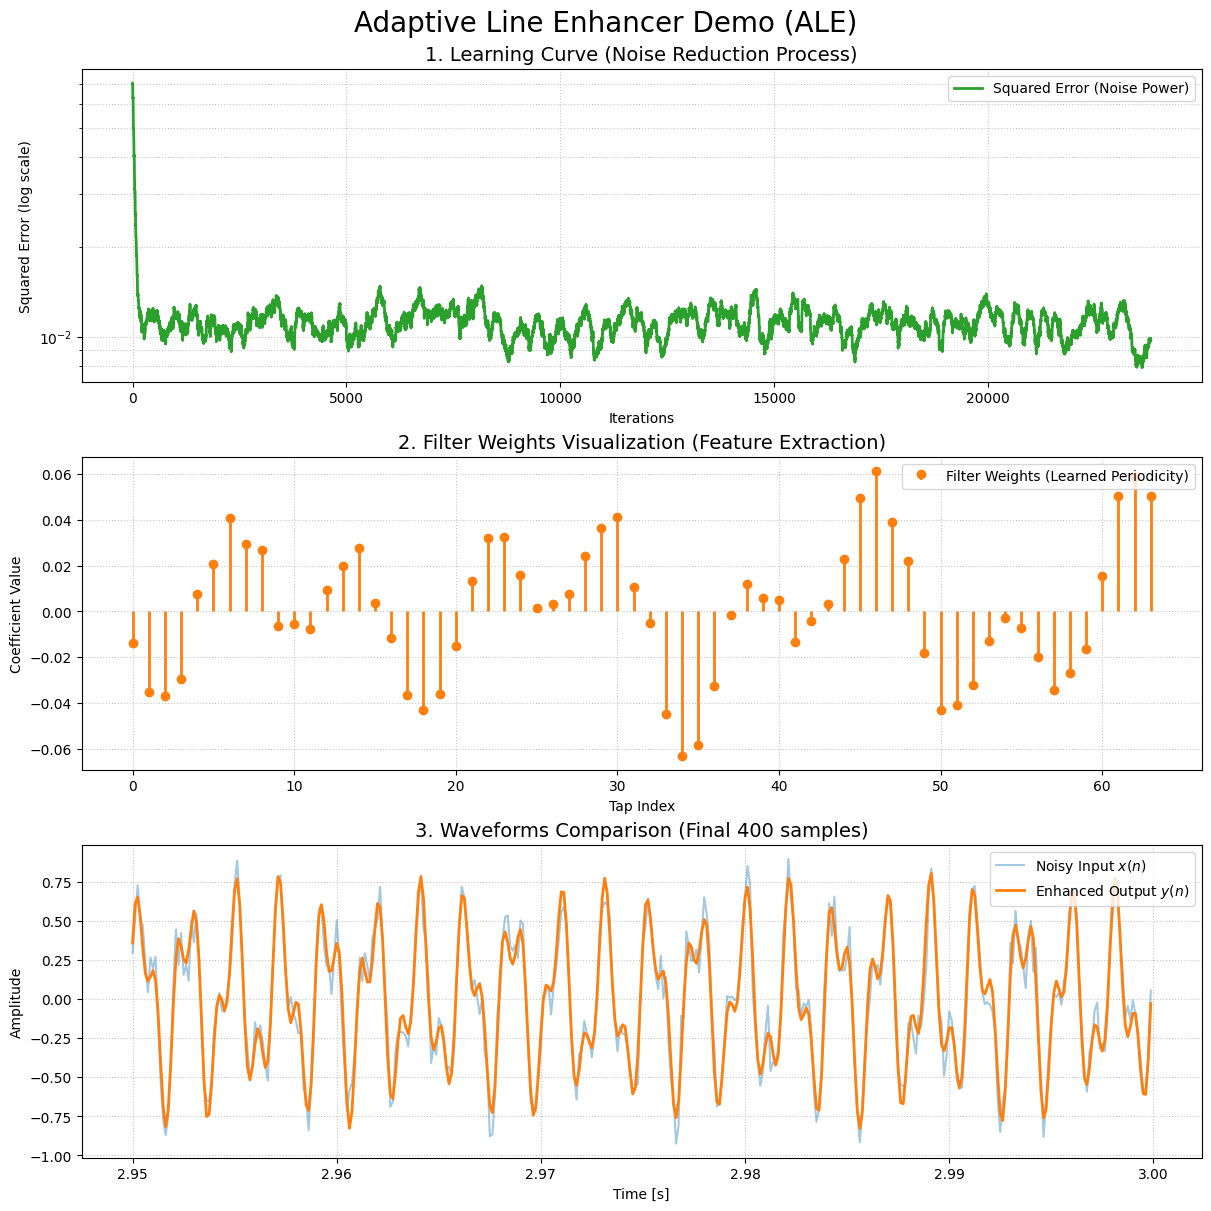


 聴き比べ (Sound Check)
1. Noisy Input (SNR: 12.30 dB)


2. Enhanced Output (SNR: 22.32 dB)


3. Error Signal (Removed Noise)


In [9]:
# @title 3. ALEシミュレーション実行 (パラメータ & SNR調整) { run: "auto" }

# --- パラメータ設定 ---
# ノイズの強さ (Noise Level): これを動かしてSNRを調整！
noise_level = 0.1 # @param {type:"slider", min:0.0, max:1.0, step:0.05}

# フィルタ長 (Filter Order)
filter_order = 64 # @param {type:"slider", min:32, max:128, step:16}

# 遅延量 (Delay Delta)
delay_delta = 10 # @param {type:"slider", min:1, max:50, step:1}

# 学習率 (Step Size)
step_size_mu = 0.005 # @param {type:"slider", min:0.001, max:0.05, step:0.001}


# --- 1. ノイズの付加とSNR計算 ---
np.random.seed(42) # 再現性のため固定
n_samples = len(clean_signal)

# 白色雑音の生成
noise = noise_level * np.random.randn(n_samples)

# 入力信号の作成 (Clean + Noise)
input_signal = clean_signal + noise

# Input SNR (Signal-to-Noise Ratio) の計算
signal_power = np.mean(clean_signal**2)
noise_power_in = np.mean(noise**2) + 1e-10
snr_in_db = 10 * np.log10(signal_power / noise_power_in)

print(f"Simulation Settings:")
print(f" - Noise Level: {noise_level}")
print(f" - Input SNR:   {snr_in_db:.2f} dB")
if snr_in_db < 0:
    print("   (注意: ノイズの方が信号より大きいです！難易度高め)")


# --- 2. ALEアルゴリズム実行 (LMS) ---
def run_ale(input_signal, filter_order, delay_delta, step_size_mu):
    n_samples = len(input_signal)
    w = np.zeros(filter_order)
    y = np.zeros(n_samples)
    e = np.zeros(n_samples) # error (input - output)
    error_log = []
    u_buffer = np.zeros(filter_order)

    for n in range(n_samples):
        if n >= delay_delta:
            u_val = input_signal[n - delay_delta]
        else:
            u_val = 0.0

        u_buffer = np.roll(u_buffer, 1)
        u_buffer[0] = u_val

        y[n] = np.dot(w, u_buffer)
        e[n] = input_signal[n] - y[n]
        w = w + step_size_mu * e[n] * u_buffer

        error_log.append(e[n]**2)

    return y, e, w, np.array(error_log)

print(f"ALEを実行中... (Order={filter_order}, Delay={delay_delta})")

y, e, w, error_log = run_ale(
    input_signal,
    filter_order,
    delay_delta,
    step_size_mu
)

print("完了。")

# --- ★追加機能: 性能評価指標の計算 ---
# 収束後のデータ（後半半分）を使って評価します
eval_start = n_samples // 2

# 1. 残留誤差 (正解信号 - ALE出力)
residual_noise = clean_signal[eval_start:] - y[eval_start:]

# 2. MSE (Mean Squared Error)
mse = np.mean(residual_noise**2)

# 3. Output SNR
noise_power_out = mse + 1e-10
snr_out_db = 10 * np.log10(signal_power / noise_power_out)

# 4. Improvement (改善量)
improvement_db = snr_out_db - snr_in_db

print("-" * 40)
print("Performance Evaluation (Latter half):")
print(f" - MSE:         {mse:.6f} (Original Signal vs Enhanced Output)")
print(f" - Output SNR:  {snr_out_db:.2f} dB")
print(f" - Improvement: +{improvement_db:.2f} dB (Noise Reduction)")
print("-" * 40)

# --- 3. 結果表示 ---
plot_ale_results(error_log, w, input_signal, y, fs)

# 音声再生
print("\n" + "="*40)
print(" 聴き比べ (Sound Check)")
print("="*40)

print(f"1. Noisy Input (SNR: {snr_in_db:.2f} dB)")
display(Audio(input_signal, rate=fs))

print(f"2. Enhanced Output (SNR: {snr_out_db:.2f} dB)")
display(Audio(y, rate=fs))

print("3. Error Signal (Removed Noise)")
display(Audio(e, rate=fs))

---
### License & Copyright
**This software is released under the MIT License.**

<small>
Copyright (c) 2026 OGAWA Tomomi (Tokyo Denki University)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>

**Contact:** <small>to.ogawa[at]ms.dendai.ac.jp</small>